In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

D:\Anaconda\envs\ml_env\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Read the Spam dataset

In [2]:
spam_data = pd.read_table("./data/SMSSpamCollection", sep="\t", header=None, names=["Label","SMS"])
spam_data.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Data Preprocessing

## Map the labels

We are to classify whether a given SMS message is a 'spam' or a 'ham'.

Let's map these categories to integer values. Specifically, we will map ham to 0 and spam to 1.

In [3]:
spam_data['Label'] = spam_data.Label.map({'ham':0, 'spam':1})
spam_data.head()

,Label,SMS
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
print("Number of SMS: ", spam_data.shape[0])

Number of SMS:  5572


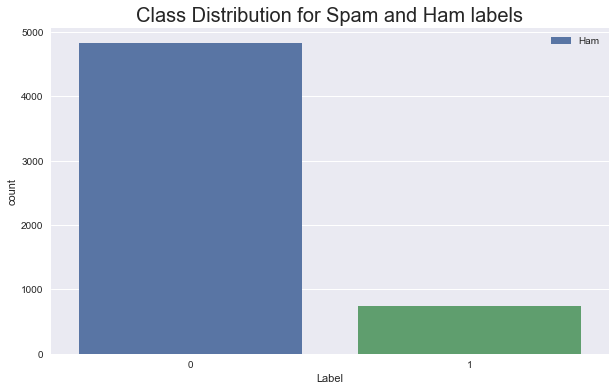

In [5]:
plt.figure(figsize=(10,6))
sns.countplot(spam_data.Label)
plt.title("Class Distribution for Spam and Ham labels", fontsize=20)
plt.legend(['Ham','Spam'])

## Bag of Words Model

Bag of words consists of three process - 
1. Tokenization - this process splits the text into 'tokens' by splitting on a given character.
2. Counting - count the occurrence of the each token in the document.
3. Normalize - diminishing importance tokens that occur in the majority of the samples/documents

Features of bag of words model are defined as the occurrence frequency of each token (with or without normalization). Then, for a corpus of documents, it is represented by a sparse matrix with one row per document and one column per token.

Bag of words process can be represented as

Tokenization -> Counting -> Normalization

Thankfully, we have scikit-learn's [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) that implements tokenization and counting in one class.

This module will convert all the text to lowercase, ignore all punctuation marks and treat them as delimitiers and accepts alphanumeric strings of length greater than or equal to 2, by default.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(lowercase=True, stop_words='english')
print(count_vect)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)


In [7]:
bag_of_words = count_vect.fit_transform(spam_data.SMS)

In [8]:
print(bag_of_words[0])

  (0, 8083)	1
  (0, 1064)	1
  (0, 3515)	1
  (0, 2007)	1
  (0, 1717)	1
  (0, 4374)	1
  (0, 8285)	1
  (0, 3555)	1
  (0, 1719)	1
  (0, 1284)	1
  (0, 2282)	1
  (0, 5779)	1
  (0, 4248)	1


In [9]:
bag_of_words.shape

(5572, 8444)

In [10]:
# Vocabulary of the corpus
len(count_vect.vocabulary_)

8444

In [11]:
bag_of_words_df = pd.DataFrame(bag_of_words.toarray(), columns=count_vect.get_feature_names())

In [12]:
bag_of_words_df.head()

,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn,ú1,〨ud
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Top 10 words in the corpus

In [13]:
word_occurence = np.sum(bag_of_words_df, axis=0)
word_occurence.sort_values(ascending=False)[:10]

ur      391
just    376
gt      318
lt      316
ok      293
free    284
ll      270
know    262
like    247
good    247
dtype: int64

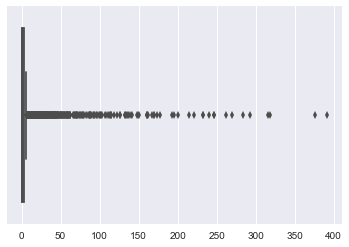

In [14]:
sns.boxplot(word_occurence)

Most of the words in the vocabulary occur not more than 50 times. 

# Naive Bayes Classification

Since we have discrete features in our model (counts of words for each SMS), we use the [multinomial Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) classifier to train our spam classification model.

Class priors for classification task our computed from the training data. This is achieved by using the default parameters provided by sklearn.

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import sklearn.metrics as mt

In [16]:
# Perform a random split into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(spam_data.SMS, spam_data.Label, test_size=0.3, random_state=42)
print("Training data shape: ", x_train.shape)
print("Testing data shape: ", x_test.shape)

Training data shape:  (3900,)
Testing data shape:  (1672,)


In [17]:
# Define CountVectorizer for Bag of Words model representation
count_vect_train = CountVectorizer(lowercase=True, stop_words='english')

# Fit and transform training data
x_train_bag = count_vect_train.fit_transform(x_train)

# Transform testing data using the parameters fit on the training data
x_test_bag = count_vect_train.transform(x_test)

print("Training data shape: ", x_train_bag.shape)
print("Testing data shape: ", x_test_bag.shape)

Training data shape:  (3900, 7004)
Testing data shape:  (1672, 7004)


In [18]:
# Fit Multinomial Naive Bayes model
multi_NB = MultinomialNB()
multi_NB.fit(x_train_bag, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Evaluation

In [19]:
pred = multi_NB.predict(x_test_bag)

In [20]:
accuracy = mt.accuracy_score(pred, y_test)
classification_report = mt.classification_report(y_pred=pred, y_true=y_test)
print("Overall Accuracy: ", accuracy)
print(classification_report)

Overall Accuracy:  0.987440191388
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      1448
          1       0.96      0.95      0.95       224

avg / total       0.99      0.99      0.99      1672



Pretty good model! We should test it with a robust cross-validation methodology like 5-fold or 10-fold cross-validation.

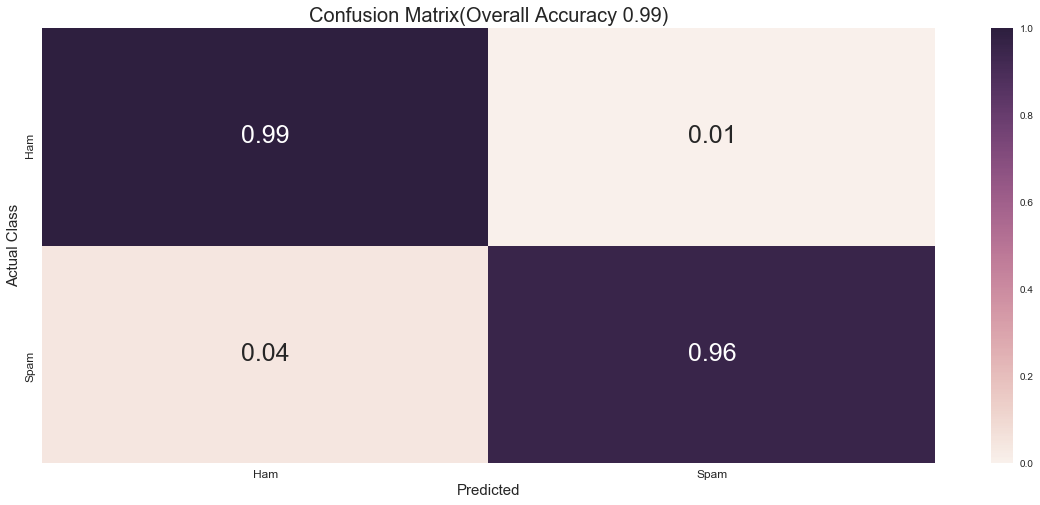

In [21]:
def plot_confusion_matrix(y_pred, y_true, labels = ['Ham','Spam'], title_text='Confusion Matrix'):
    plt.figure(figsize=(20,8))
    # Compute confusion matrix
    cm = mt.confusion_matrix(y_pred, y_true)
    acc = np.sum(cm.diagonal())/np.sum(cm)
    cm_2 = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm_2, annot=True, fmt='.2f', vmin=0,vmax=1,xticklabels=labels, yticklabels=labels,
               annot_kws={'size':25})
    plt.title(title_text+"(Overall Accuracy {:0.2f})".format(acc), fontsize=20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Predicted', fontsize=15)
    plt.ylabel('Actual Class', fontsize=15)

plot_confusion_matrix(pred,y_test)